In [2]:
from glob import glob
import os

import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot as plt

from rdkit import Chem
import numpy as np

import os
import glob

In [28]:


# positive_labels = [1] * 50
# negative_labels = [0] * 50
# ordered_labels = positive_labels + negative_labels

ligand_data = pd.read_csv("mchr1/ligand_data/242310_sampled_dataset.csv")
ligand_data = ligand_data.set_index("smiles")

output_dir = "results_October/af2_active_14"

labels = []
ligand_ids = []
confidences = []
affinities = []
cnn_scores = []

# pocket_data = [
#     ("results/alphaflow_0", "kalasanty_results/alphaflow0/pocket1.mol2"),
#     ("results/alphaflow_1", "results/alphaflow_1/ligand_47/minimized.sdf"),
#     ("results/alphaflow_2", "kalasanty_results/alphaflow2/pocket1.mol2"),
#     ("results/alphafold_gpcr", "kalasanty_results/af2_inactive/pocket1.mol2"),
#     ("results/alphafold_gpcr_active_2", "kalasanty_results/af2_active/pocket1.mol2"),
#     ("results/esmflow_0", "kalasanty_results/esmflow0/pocket1.mol2"),
#     ("results/esmflow_1", "kalasanty_results/esmflow1/pocket0.mol2"),
#     ("results/esmflow_2", "results/esmflow_2/ligand_80/minimized.sdf"),
#     ("results/Q99705_model.active.crderr.pdb", "kalasanty_results/rosettafold_active/pocket0.mol2"),
#     ("results/Q99705_model.inactive.crderr.pdb", "kalasanty_results/rosettafold_inactive/pocket0.mol2"),
# ]
# result_to_pocket = {result: pocket for result, pocket in pocket_data}
    

ligand_dirs = glob.glob(os.path.join(output_dir, "*"))
ligand_dirs = [p for p in ligand_dirs if os.path.isdir(p)]
ligand_dirs = sorted(ligand_dirs, key=lambda x: int(os.path.basename(x).split("_")[1]))

diffdock_input = pd.read_csv(os.path.join(output_dir, "diffdock_input.csv"))
diffdock_input = diffdock_input.set_index("complex_name")

for ligand_dir in ligand_dirs:
    try:
        ranked_poses = os.listdir(ligand_dir)
        ranked_poses = [p for p in ranked_poses if p.endswith(".sdf") and "confidence" in p]
        ranked_poses = sorted(ranked_poses, key=lambda x: int(x.split("_")[0].replace("rank", "")))
        if not ranked_poses:
            print("Empty directory: {}".format(ligand_dir))
            continue
        ligand_id = os.path.basename(ligand_dir)
        ligand_id = int(ligand_id.split("_")[1])
        
        minimize_pose = glob.glob(os.path.join(ligand_dir, "minimized*.sdf"))[0]
        rank = int(os.path.basename(minimize_pose).replace("minimized_rank", "").replace(".sdf", ""))
        
        for pose in ranked_poses:
            confidence = None
            if f"rank{rank}_" in pose:
                ligand_file_name = pose.replace(".sdf", "")
                confidence = ligand_file_name.replace(f"rank{rank}_confidence", "")
                confidence = float(confidence)
                break
            
        with open(glob.glob(os.path.join(ligand_dir, "minimized*.sdf"))[0]) as f:
            lines = f.readlines()
            for i, line in enumerate(lines):
                if "<minimizedAffinity>" in line:
                    affinity = float(lines[i+1])
                if "<CNNscore>" in line:
                    cnn_score = float(lines[i+1])
        ligand_ids.append(ligand_id)
        
        ligand_smiles = diffdock_input.loc[os.path.basename(ligand_dir), "ligand_description"]
        label = ligand_data.loc[ligand_smiles, "activity"]
        labels.append(label)
        
        confidences.append(confidence)
        affinities.append(affinity)
        cnn_scores.append(cnn_score)
    except Exception as e:
        print("On directory: {}. Error: {}".format(ligand_dir, e))
        # raise e
    
results = pd.DataFrame({"ligand_id": ligand_ids, "label": labels, "confidence": confidences, "affinity": affinities, "cnn_score": cnn_scores})
results.to_csv(os.path.join(output_dir, "scores.csv"), index=False)

On directory: results_October/af2_active_13/ligand_8. Error: list index out of range
On directory: results_October/af2_active_13/ligand_25. Error: list index out of range
On directory: results_October/af2_active_13/ligand_33. Error: list index out of range
On directory: results_October/af2_active_13/ligand_42. Error: list index out of range
On directory: results_October/af2_active_13/ligand_48. Error: list index out of range
On directory: results_October/af2_active_13/ligand_54. Error: list index out of range
On directory: results_October/af2_active_13/ligand_60. Error: list index out of range
On directory: results_October/af2_active_13/ligand_93. Error: list index out of range
On directory: results_October/af2_active_13/ligand_104. Error: list index out of range
On directory: results_October/af2_active_13/ligand_114. Error: list index out of range
On directory: results_October/af2_active_13/ligand_121. Error: list index out of range
On directory: results_October/af2_active_13/ligand_1

In [29]:
def normalize(scores: list):
    max_score = max(scores)
    min_score = min(scores)
    return [(score - min_score) / (max_score - min_score) for score in scores]

def reverse(scores: list):
    return [1 - score for score in scores]

normalized_confidences = normalize(confidences)
normalized_affinities = normalize(affinities)
normalized_cnn_scores = normalize(cnn_scores)

# normalized_confidences = reverse(normalized_confidences)
normalized_affinities = reverse(normalized_affinities)

AUC-ROC confidence:  0.3451704545454546
AUC-ROC affinity:  0.5689229249011857
AUC-ROC CNN score:  0.4656620553359684


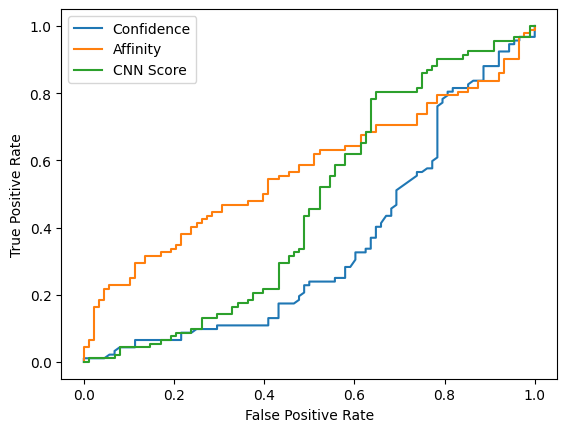

In [30]:
confidence_fpr, confidence_tpr, _ = roc_curve(labels, normalized_confidences)
affinity_fpr, affinity_tpr, _ = roc_curve(labels, normalized_affinities)
cnn_fpr, cnn_tpr, _ = roc_curve(labels, normalized_cnn_scores)

print("AUC-ROC confidence: ", roc_auc_score(labels, normalized_confidences))
print("AUC-ROC affinity: ",roc_auc_score(labels, normalized_affinities))
print("AUC-ROC CNN score: ",roc_auc_score(labels, normalized_cnn_scores))

plt.plot(confidence_fpr, confidence_tpr, label="Confidence")
plt.plot(affinity_fpr, affinity_tpr, label="Affinity")
plt.plot(cnn_fpr, cnn_tpr, label="CNN Score")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

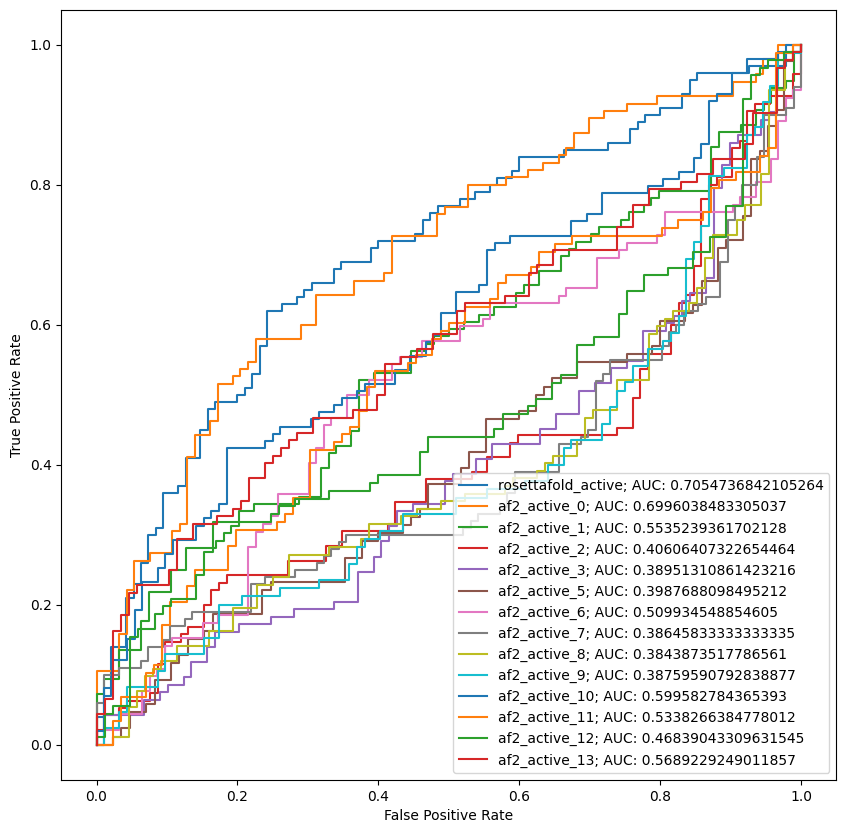

In [34]:
score_files = [
    "results_October/rosettafold_active/scores.csv",
    "results_October/af2_active_0/scores.csv",
    "results_October/af2_active_1/scores.csv",
    "results_October/af2_active_2/scores.csv", 
    "results_October/af2_active_3/scores.csv",
    # "results_October/af2_active_4/scores.csv",
    "results_October/af2_active_5/scores.csv",
    "results_October/af2_active_6/scores.csv",
    "results_October/af2_active_7/scores.csv",
    "results_October/af2_active_8/scores.csv",
    "results_October/af2_active_9/scores.csv",
    "results_October/af2_active_10/scores.csv",
    "results_October/af2_active_11/scores.csv",
    "results_October/af2_active_12/scores.csv",
    "results_October/af2_active_13/scores.csv",
]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for score_file in score_files:
    scores = pd.read_csv(score_file)
    normalized_scores = normalize(scores["affinity"])
    normalized_scores = reverse(normalized_scores)
    fpr, tpr, _ = roc_curve(scores["label"], normalized_scores)
    auc = roc_auc_score(scores["label"], normalized_scores)
    label = score_file.split("/")[1]
    ax.plot(fpr, tpr, label=f"{label}; AUC: {auc}")
ax.legend()
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
plt.show()